In [211]:

import followthemoney as ftm
import followthemoney.model as model
import pandas
import json
import numpy as np
import math
from urllib import parse as url_parse
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as metrics 
from sklearn.preprocessing import OneHotEncoder
import seaborn as sb

# Importing and preprocessing

In [212]:
# local import for easier reproducibility 
json_path = "./data/meineabgeordneten_3.json"

entity_dicts = []
with open(json_path) as f:
    for line in f:
        entity_dicts.append(json.loads(line))

In [213]:
person_dicts = [entity for entity in entity_dicts if entity["schema"] == "Person"]
ftm_proxies =[model.get_proxy(entity) for entity in entity_dicts]
ftm_persons = [proxy for proxy in ftm_proxies if proxy.schema.name == "Person"]
ftm_organizations = [proxy for proxy in ftm_proxies if proxy.schema.name == "Organization"]
ftm_companies = [proxy for proxy in ftm_proxies if proxy.schema.name == "Company"]
person_assignments = pandas.read_csv("./data/csv/new/Person_wikidata.csv")[["id", "wikidata"]]
#person_assignments.where(pandas.notnull(person_assignments, None))
#person_assignments.loc[person_assignments["wikidata"] == pandas.NA] = None
#person_assignments = person_assignments["wikidata"].to_frame().loc[person_assignments["wikidata"] == "na", pandas.NA]

In [214]:
person_assignments

,id,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,Q50843964
...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN
764,fe532c498a07fc06380579af855e68389239c43b,Q19501935


In [215]:
print(len(ftm_persons), len(person_assignments))

766 766


All properties of entities are multivalued, although they mostly hold only one single value. I transform the data in order to call the API with single-valued properties.

In [216]:
flat_entities = []
for entity in ftm_persons:
    prop_dict ={}
    for prop, val in entity.properties.items():
        prop_dict["id"] = entity.id
        prop_dict[prop] = val[0] if len(val)== 1 else  val
    flat_entities.append(prop_dict)


In [217]:
# Dataframe with Wikidata Cells
clean_person_df = pandas.DataFrame.from_dict(flat_entities).merge(person_assignments,on="id")
clean_person_df

,id,birthDate,birthPlace,country,email,firstName,lastName,name,sourceUrl,summary,website,title,wikidata
0,00023638949ec143e690ae151d28e389574f07dc,1987-02-23,Innsbruck,at,buero.wohlgemuth@oegb.at,Philip,Wohlgemuth,Philip Wohlgemuth,https://www.meineabgeordneten.at/Abgeordnete/p...,Abgeordneter zum Landtag,"[https://www.facebook.com/philip.wohlgemuth, h...",NaN,Q51533040
1,001d48bf2913572202d88f00e35262f490771b40,1976-06-25,Wiener Neustadt,at,waltraud.ungersboeck@noel.gv.at,Waltraud,Ungersböck,Waltraud Ungersböck,https://www.meineabgeordneten.at/Abgeordnete/W...,"[Vizebürgermeisterin, Abgeordnete zum Landtag,...",[https://www.facebook.com/profile.php?id=10001...,NaN,Q81526090
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,1971-02-27,Rottenmann,at,armin.forstner@stvp.at,Armin,Forstner,Armin Forstner,https://www.meineabgeordneten.at/Abgeordnete/a...,"[Natur- und Geopark Steirische Eisenwurzen, St...",https://www.facebook.com/a.forstner/,NaN,Q20752545
3,00def69ad3d13efe8151da80f1485a692954d183,1980-10-20,Wien,at,spassfabrik@gmx.at,Silvia,Janoch,Silvia Janoch,https://www.meineabgeordneten.at/Abgeordnete/s...,"[KINDERGRUPPE SPASSFABRIK, Abgeordnete zum Wie...",https://www.facebook.com/silvia.janoch,Dipl.-Päd.,Q102353097
4,00e70efc17aff680e675349ca87d7b80be04c452,1970-07-10,Eisenstadt,at,elvira.schmidt@spoe.at,Elvira,Schmidt,Elvira Schmidt,https://www.meineabgeordneten.at/Abgeordnete/e...,"[Mitglied des Gemeinderates, Abgeordnete zum L...",https://www.facebook.com/virli.schmidt,NaN,Q50843964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,fcc94a122228733902b6f601abc54631aa205a4b,1963-01-16,Radstadt,at,liesl.weitgasser@neos.eu,Elisabeth,Weitgasser,Elisabeth Weitgasser,https://www.meineabgeordneten.at/Abgeordnete/e...,"[Abgeordnete zum Landtag, S-berg Hotel Ges.m.b...","[https://www.instagram.com/weitgasserliesl/, h...",NaN,Q54956531
762,fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,1966-11-04,Wien,at,elisabeth.trummer.spoe@gmail.com,Elisabeth,Trummer,Elisabeth Trummer,https://www.meineabgeordneten.at/Abgeordnete/e...,"[""Sozial- und Gesundheitsplattform Oberpullend...",https://www.facebook.com/Trummerelisabeth,NaN,Q84091498
763,fdc8f2275cf8bea8331ea4a779755915d0c29363,NaN,NaN,at,daniela.schmid@ages.at,Daniela,Schmid,Daniela Schmid,https://www.meineabgeordneten.at/Abgeordnete/d...,NaN,NaN,Priv.-Doz.in Dr.in,NaN
764,fe532c498a07fc06380579af855e68389239c43b,1964-06-30,Graz,at,andrea-michaela.schartel@parlament.gv.at,Andrea Michaela,Schartel,Andrea Michaela Schartel,https://www.meineabgeordneten.at/Abgeordnete/A...,"[Mitglied des Bundesrates, RSP-Personalverrech...",[https://www.linkedin.com/in/andrea-schartel-8...,NaN,Q19501935


# Reconciliation

In [218]:
import requests
import urllib
reconciliation_endpoint = urllib.parse.urlparse("https://wikidata.reconci.link/de/api")

Ontology alignment for subset of Person properties.

In [219]:
mapping = {
    "birthDate" : "P569",
    "birthPlace" : "P19",
    "email" : "P968",
    "firstName" : "P735",
    "lastName" : "P734",
    "title" : "P512",
    "website" : "P856"
}

In [220]:
# email field emitting leads to higher scores, but matchign decision same

In [221]:
def createQuery(entity, type, limit = 10):
    if entity.schema.name != "Person":
        return null
    query_params = {}
    query_params["query"] = entity.first("name")
    query_params["type"] = type
    query_params["properties"] = []
    query_params["limit"] = limit # candidate limit
    for prop, value in entity.properties.items():
        #print(prop, mapping.get(prop))
        wikidataId = mapping.get(prop)
        if wikidataId:
            prop = {"pid": wikidataId, "v": value[0] if len(value)== 1 else  value}
            query_params["properties"].append(prop)   
 
    return query_params
    


In [222]:
createQuery(ftm_persons[3], "Q5")

{'query': 'Silvia Janoch',
 'type': 'Q5',
 'properties': [{'pid': 'P569', 'v': '1980-10-20'},
  {'pid': 'P19', 'v': 'Wien'},
  {'pid': 'P968', 'v': 'spassfabrik@gmx.at'},
  {'pid': 'P735', 'v': 'Silvia'},
  {'pid': 'P734', 'v': 'Janoch'},
  {'pid': 'P512', 'v': 'Dipl.-Päd.'},
  {'pid': 'P856', 'v': 'https://www.facebook.com/silvia.janoch'}],
 'limit': 10}

In [223]:
def create_batch_queries(entities, type, batch_size = 10):
    start = 0
    end = 0 + batch_size
    batches =[]
    for batch_nr in range(math.ceil(len(entities)/batch_size)):
        queries = {"q"+str(i):createQuery(entity, "Q5") for i, entity in enumerate(ftm_persons[start:end])}
        batches.append(queries)
        start += batch_size
        end += batch_size
    return batches
    

In [224]:
def query_endpoint(query_batches):
    results = []
    for batch_query in query_batches:
        # Endpoint only accepts double quotes, not single quotes.
        urlencoded = url_parse.quote_plus(json.dumps(batch_query))
        response = requests.get(reconciliation_endpoint.geturl()+ "?queries=" + urlencoded)
        results.extend([resp for index, resp in response.json().items()])
    return results

In [225]:
%time
# Commented out due to reproducibility reasons. API requests take some time and may return different results later on.
if False:
    batch_query = create_batch_queries(ftm_persons, "Q5") # Q5 is the Wikidata ID for type "Human".
    results = query_endpoint(batch_query)
    #json.dump(results, open("./data/intermediate/api_responses.json","w"))
else:
    results = json.load(open("./data/intermediate/api_responses.json"))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


# Analysis

Knitting together API response and data to create a pandas table for further processing. 

In [231]:

intermed_table = []
header = ["id", "name", "cd_wd_id", "cd_name","cd_match_pred", "cd_score"]
for result, entity in zip(results, ftm_persons):
    candidates = result["result"]
    if len(candidates) > 0: 
        for candidate in candidates:
            intermed_table.append([entity.id,entity.first("name"), candidate["id"], candidate["name"], \
                candidate["match"], candidate["score"]])
    # If no results in response
    else: 
        intermed_table.append([entity.id,entity.first("name"), None, None, \
            False, None]) # implicit false made explicit

cd_table = pandas.DataFrame(intermed_table, columns= header).merge(person_assignments,on="id")
cd_table["match"] = cd_table["wikidata"] == cd_table["cd_wd_id"]
#cd_table["match"] = np.select([
#    cd_table["match"]
#],["match"], default="no_match")
#cd_table.loc[cd_table["match"]] = "match"
#cd_table.loc[~cd_table["match"].] = "no_match"
#cd_table["wikidata"] = cd_table["wikidata"].astype(str)
#cd_table["cd_wd_id"] = cd_table["cd_wd_id"].astype(str)
cd_table


,id,name,cd_wd_id,cd_name,cd_match_pred,cd_score,wikidata,match
0,00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,76.470588,Q51533040,True
1,001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,76.470588,Q81526090,True
2,00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,False,64.705882,Q20752545,True
3,00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,47.368421,Q102353097,True
4,00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,76.470588,Q50843964,True
...,...,...,...,...,...,...,...,...
1446,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q89189322,Daniela Schmidt,False,66.846154,NaN,False
1447,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q97706069,Daniela Schmidt,False,66.846154,NaN,False
1448,fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q97706899,Daniela-Felicitas Schmid,False,28.461538,NaN,False
1449,fe532c498a07fc06380579af855e68389239c43b,Andrea Michaela Schartel,Q19501935,Andrea-Michaela Schartel,True,76.470588,Q19501935,True


Before calculating scores based on similarity measures, the Wikidata Reconciliation API performs a candidate selection based on the WikiMedia API Elasticsearch search-engine by querying the value in the "query" property inside the request, which corresponds to the name of an item (at least in the OpenRefine implementation, as well as here). Obviously, there is a high tendency to return just one matching result.

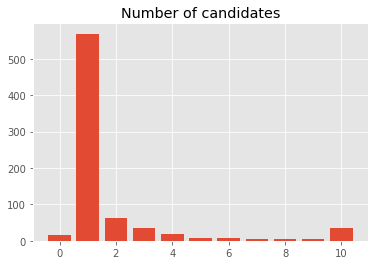

In [227]:
cd_num_counts = pandas.DataFrame([len(result["result"]) for result in results], columns=["cd_num"])
cd_occ_counts =  cd_num_counts.groupby("cd_num").size().to_frame("count")

plt.bar(cd_occ_counts.index, cd_occ_counts["count"])
plt.title("Number of candidates")
plt.style.use("ggplot")

In [228]:
#cd_table["is_match"] = cd_table["match"] and (cd_table["cd_wd_id"] == cd_table["wikidata"]] 
cd_first_candidate = cd_table.groupby("id").first()
cd_first_candidate

,name,cd_wd_id,cd_name,cd_match_pred,cd_score,wikidata,match
id,,,,,,,
00023638949ec143e690ae151d28e389574f07dc,Philip Wohlgemuth,Q51533040,Philip Wohlgemuth,True,76.470588,Q51533040,True
001d48bf2913572202d88f00e35262f490771b40,Waltraud Ungersböck,Q81526090,Waltraud Ungersböck,True,76.470588,Q81526090,True
00ad3c5b5a651f6e00080803ffefb1d306c6d027,Armin Forstner,Q20752545,Armin Forstner,False,64.705882,Q20752545,True
00def69ad3d13efe8151da80f1485a692954d183,Silvia Janoch,Q102353097,Silvia Janoch,False,47.368421,Q102353097,True
00e70efc17aff680e675349ca87d7b80be04c452,Elvira Schmidt,Q50843964,Elvira Schmidt,True,76.470588,Q50843964,True
...,...,...,...,...,...,...,...
fcc94a122228733902b6f601abc54631aa205a4b,Elisabeth Weitgasser,Q54956531,Elisabeth Weitgasser,False,64.705882,Q54956531,True
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e,Elisabeth Trummer,Q84091498,Elisabeth Trummer,True,76.470588,Q84091498,True
fdc8f2275cf8bea8331ea4a779755915d0c29363,Daniela Schmid,Q87653139,Daniela Schmid,False,69.230769,NaN,False


As the data is about person of interests, it is heavly biased towards well known entities that actually have a Wikidata (and Wikipedia) page, which corresponds to the scenario layed out in the thesis.

Text(0.5, 1.0, 'Well known entities - Number of items existing on Wikidata')

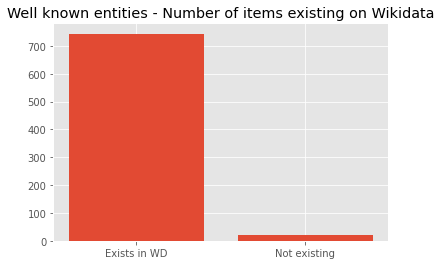

In [229]:
has_match = ~cd_first_candidate["wikidata"].isna()
has_match.value_counts()
plt.bar(["Exists in WD", "Not existing"],has_match.value_counts())
plt.title("Well known entities - Number of items existing on Wikidata")



## Overview 
The threshold of Wikidata's Reconciliation Service was automatically set by the service, following this equation:

$t = t_{val} - d \cdot |p| = 95 - 5 \cdot |p|$

where:<br>
$t_{val}$ ... the fixed validation threshold set by the service. This value is statically set to 95<br>
$d$ ... The fixed validation discount set by the service. This value is statically set to 5 <br>
$p$ ... The set of properties queried

In most cases the property size was 6, leading to a threshold of 65. 

Candidates that exceeded this threshold are considered as a match. Other candidates returned demand further human judgment. The service does not offer partial matches, which would require a second (lower) threshold. However, the service reveals candidate to the user for further judgement. The size of candidates is limited to 10 Candidates for this case. 

Record Linkage regarding Wikidata may return a maximum of 1 match, as Wikidata itself generally does not hold duplicates (although there are exceptions).


# Evaluating Matching decisions
Firstly, filter out cases, where no Wikidata item exists, as there are no relevant entities, which are needed for computing precision and recall measures. In this case 21 entities are filtered out.

In [243]:
cd = cd_table[~cd_table["wikidata"].isna()]

In [354]:
449/744


0.603494623655914

In [381]:
cd_first= cd.groupby("id").first()
cd_first_metrics = { 
    "acc": metrics.accuracy_score(cd_first["cd_match_pred"], cd_first["match"]),
    "prec": metrics.precision_score(cd_first["cd_match_pred"], cd_first["match"]),
    "rec": metrics.recall_score(cd_first["cd_match_pred"], cd_first["match"])
}
cd_first_metrics


{'acc': 0.6075268817204301, 'prec': 0.6059379217273954, 'rec': 1.0}

In [391]:

cd["tp"] = cd["match"] & cd["cd_match_pred"]
any_cd_match = cd[["match", "tp"]].groupby(cd["id"]).any()#.to_frame("any_cd_match")
any_cd_match["match_category"] = np.select([
    any_cd_match["match"] & any_cd_match["tp"],
    any_cd_match["match"]
],[ "full_match", "candidate_match"], default="no_match")
any_cd_match["match_category"].value_counts()


<ipython-input-391-7cb69d1b1919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["tp"] = cd["match"] & cd["cd_match_pred"]


full_match         449
candidate_match    294
no_match             1
Name: match_category, dtype: int64

### Overview
Overview on the decisions of the service: Most decisions are right (full_match). In the majority of cases the true entity is in the set of candidate. There is only one example, where this is not the case.

<BarContainer object of 3 artists>

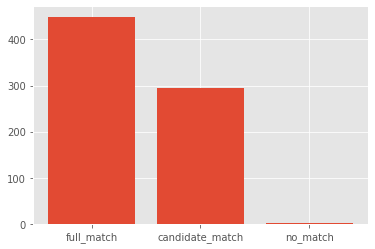

In [249]:
match_category = any_cd_match["match_category"].value_counts()
plt.bar(match_category.index,match_category)


In [255]:
cd["cd_wd_id"] = cd["cd_wd_id"].astype(str)
cd["wikidata"] = cd["wikidata"].astype(str)

<ipython-input-255-5f16342cda76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["cd_wd_id"] = cd["cd_wd_id"].astype(str)
<ipython-input-255-5f16342cda76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["wikidata"] = cd["wikidata"].astype(str)


## Macro Averaged Precision and Recall

In [392]:
cd["match"].value_counts()

True     743
False    661
Name: match, dtype: int64

Due to the balanced classes distribution in dataset of candidates, I choosed MACRO averaged metrics.

In [382]:
queryy =[]
cd_metrics = []
for name, query in cd.groupby("id"):
    queryy.append(query)
    metric = { 
        "acc": metrics.accuracy_score(query["cd_match_pred"], query["match"]),
        "prec": metrics.precision_score(query["cd_match_pred"], query["match"]),
        "rec": metrics.recall_score(query["cd_match_pred"], query["match"])
    }
    #prec = metrics.accuracy_score(query["cd_match_pred"].values,query["match"].values)
    cd_metrics.append(metric)
    #print(len(query))

#https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0

/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/peter/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [386]:
pandas.DataFrame(cd_metrics).mean()

acc     0.644812
prec    0.603495
rec     0.603495
dtype: float64

<AxesSubplot:>

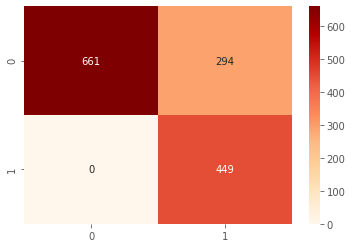

In [307]:
mtr = metrics.confusion_matrix(cd["cd_match_pred"].values,cd["match"].values)
sb.heatmap(mtr,  annot=True,cmap="OrRd", fmt="g")
#makes no sense because candidates TODO

In [388]:
cd_first_candidate["fp"] = (cd_first_candidate["cd_match_pred"] & ~cd_first_candidate["match"])

## Evaluating the Ranking
The Wikidata Reconciliation API makes rather conservative decisions, surfacing no false positives. However, the majority is seen as partial match, putting the right item always inside the list of candidates, but without making a decision.

In [ ]:
conf_matr = metrics.confusion_matrix(cd_first_candidate["match"], cd_first_candidate["estimate"])

In [173]:
conf_matr = metrics.confusion_matrix(cd_first_candidate["match"], cd_first_candidate["estimate"])
df =pandas.DataFrame(conf_matr[0:2])
df.columns = ["partial_match", "no_match", "match"]
df.index = ["match", "no match"]
df = df[["match", "partial_match", "no_match"]]
# Subscript of confusion matrix due to the fact that the estimator has more classes than the actual label. 
sb.heatmap(df, annot=True,cmap="OrRd", fmt="g")
plt.xlabel("predicted")
plt.ylabel("true")


KeyError: 'estimate'

In [206]:
truth = cd_first_candidate["wikidata"].values
estimate 
{"precision:" : metrics.precision_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values, average="macro")}

{'precision:': 0.9673629242819843}

In [191]:
#metrics.top_k_accuracy_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values )

metrics.accuracy_score(cd_first_candidate["wikidata"].values,cd_first_candidate["cd_wd_id"].values)

TypeError: '<' not supported between instances of 'str' and 'float'

In [113]:
onehot = OneHotEncoder(sparse=False)

In [128]:
cd_first_candidate["cd_wd_id"]

id
00023638949ec143e690ae151d28e389574f07dc     Q51533040
001d48bf2913572202d88f00e35262f490771b40     Q81526090
00ad3c5b5a651f6e00080803ffefb1d306c6d027     Q20752545
00def69ad3d13efe8151da80f1485a692954d183    Q102353097
00e70efc17aff680e675349ca87d7b80be04c452     Q50843964
                                               ...    
fcc94a122228733902b6f601abc54631aa205a4b     Q54956531
fd6b5ddebf7ed34449bac5a96eb2acbdbf5e4a3e     Q84091498
fdc8f2275cf8bea8331ea4a779755915d0c29363     Q87653139
fe532c498a07fc06380579af855e68389239c43b     Q19501935
fea62afd157dd3f7ec3253d21547bb3b0a6f30bf     Q81616188
Name: cd_wd_id, Length: 766, dtype: object